In [1]:
# !pip install pip --upgrade
import numpy as np
from scipy import spatial
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

import pandas as pd
# !pip install pyopenssl --upgrade
# !pip install --upgrade smart_open
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string

# for processing
import re
import nltk
from nltk.tokenize import word_tokenize


from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('display.max_colwidth', None)

from datetime import datetime
from nltk.tokenize import RegexpTokenizer

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
import numpy as np
import pandas as pd

In [2]:
%%time
embeddings_dict_6B_50D = {}
with open("glove.6B/glove.6B.50d.txt", 'r', encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = ' '.join(values[:-50]).lower().strip()
        vector = np.asarray(values[-50:], "float32")
        embeddings_dict_6B_50D[word] = vector
        
def vectorize_text_50(text):
    vectors = [embeddings_dict_6B_50D.get(word) for word in str(text).split() if word in embeddings_dict_6B_50D]
    vectors = [v for v in vectors if v is not None]  # remove any None values
    if vectors:
        vectorized = np.mean(vectors, axis=0)
    else:
        vectorized = np.zeros(50)  # if there are no vectors, return a zero-vector
    return vectorized

Wall time: 3.85 s


In [3]:
%%time
embeddings_dict_6B_100D = {}
with open("glove.6B/glove.6B.100d.txt", 'r', encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = ' '.join(values[:-100]).lower().strip()
        vector = np.asarray(values[-100:], "float32")
        embeddings_dict_6B_100D[word] = vector
        
def vectorize_text_100(text):
    vectors = [embeddings_dict_6B_100D.get(word) for word in str(text).split() if word in embeddings_dict_6B_100D]
    vectors = [v for v in vectors if v is not None]  # remove any None values
    if vectors:
        vectorized = np.mean(vectors, axis=0)
    else:
        vectorized = np.zeros(100)  # if there are no vectors, return a zero-vector
    return vectorized

Wall time: 7.58 s


In [4]:
def text_normalizer(text):
    if text:
        # Use NLTK RegexpTokenizer for tokenization. 
        # This tokenizer splits the text by white space and also keeps tokens like "wasn't" and "don't".
        tokenizer = RegexpTokenizer(r'\b\w[\w\'-]*\w\b|\w')
        words = tokenizer.tokenize(text)

        # Clean up any token with repeating characters like '666', 'aaa', '!!!!!!', substitute them with empty string ''.
        # This includes 'XXXX' maskings in the text created by CFPB.
        words = [re.sub(r'(\w)\1{2,}', '', word) if re.search(r'(\w)\1{2,}', word) else word for word in words]

        # Convert to lowercase and remove punctuations.
        words = [word.lower().strip() for word in words]

        # Substitute the tokens with "" where they are just numbers.
        words = ['' if word.isdigit() else word for word in words]

        # Join the words back into a single string.
        text = ' '.join([word for word in words if word])
    
    return text

In [5]:
%%time
cfpb_df = pd.read_csv("CFPB with Duplicate Marked NEW.csv")
print(cfpb_df.shape)

<timed exec>:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.


(1300361, 24)
Wall time: 23.5 s


In [6]:
# Drop duplicates based on 'dupi_id' column
cfpb_df = cfpb_df.drop_duplicates(subset='dupi_id')
print(cfpb_df.shape)

(1083240, 24)


<AxesSubplot:ylabel='Frequency'>

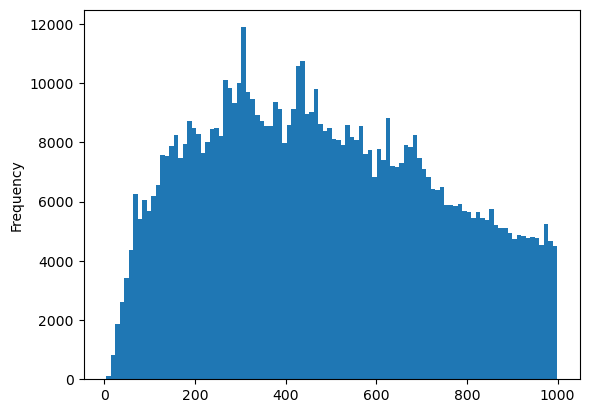

In [7]:
cfpb_df[cfpb_df['narr_len']<1000]['narr_len'].plot(kind='hist', bins=100) 

In [8]:
cfpb_df[(cfpb_df['narr_len']<300)&(cfpb_df['narr_len']>200)].sample(10)[['Consumer complaint narrative','Product']]

,Consumer complaint narrative,Product
405742,"After resetting my password, temporary passcodes take 8+ hours to arrive. So when I attempt to login to my computer I have to plan my life a day ahead of time. XXXX XXXX Back refuses to send me these passcodes",Credit card or prepaid card
337673,Sent certified mail to all three bureau on XX/XX/2021. Only bureau to respond was XXXX and they stated the could find no record of me. I have personally pulled all three of my credit bureau so not sure how this could be. I have proof of certified mail.,"Credit reporting, credit repair services, or other personal consumer reports"
809111,"Received a letter in the mail today XXXX XXXX2021. It is from XXXX XXXX XXXX and Midland Credit Management , Inc., in the amount of {$1000.00}. This was discharged quite a while again in a bankruptcy claim.",Debt collection
474067,I mailed a check to settle a collection account for less then full balance. Check was received and credited on XX/XX/XXXX however on XX/XX/XXXX company reported the account to all 3 credit bureaus as an open collection with an adjusted balance due to reflect the settlement payment.,"Credit reporting, credit repair services, or other personal consumer reports"
739085,Someone opened a credit card in my name and ssn I have spoken with XXXX XXXX and they say the card was opened with a New Jersey address and we live in Louisiana the card is with Celtic bank/continental finance it was opened XXXX/XXXX/21,Credit card or prepaid card
1007423,I was denied extended repayment option based on incorrect information. My loans were disbursed between XXXX through XXXX. Nelnet claimed wrongly in their communication to me that my loan was awarded prior to XXXX.,Student loan
11372,Please open attachment. American Express has violated my federal rights Pursuant to 15 usc 1602 ( p ) and 1602 ( n ). They have not responded to my communication or have done what Ive demanded of them.,Credit card or prepaid card
772418,"I had account with Wells Fargo sense 2003, and I was trying to see if I was one of those who had overdraft fees and other things so my account was closed do to none activity which shouldnt have happened.",Checking or savings account
710617,"I natural person, consumer, and creditor PULLED MY CONSUMER REPORT AND SEE UNAUTHORIZED REPORTINGS OF ACCOUNTS ON MY REPORT. THE COMPANY IS IN VIOLATION OF : 15 USC 1681 ( a ) ( 4 ) 15 USC 1681 ( a ) ( 2 ) ( b ) 15 USC 1681 ( b ) ( a ) ( 2 ) 15 USC 1681 ( b ) ( 2 ) ( a ) 15 USC 1681 ( c ) ( 2 )","Credit reporting, credit repair services, or other personal consumer reports"
513265,I am a victim of identity theft. I do not know these companies and I have reached out to them regarding these accounts to verify/validate the accuracy and send proper documentation. I have not received any correspondence reference to these accounts.,"Credit reporting, credit repair services, or other personal consumer reports"


In [9]:
cfpb_df['narr_len'].quantile(.16)

274.0

In [10]:
cfpb_df.columns

Index(['Unnamed: 0', 'Date received', 'Product', 'Sub-product', 'Issue',
       'Sub-issue', 'Consumer complaint narrative', 'Company public response',
       'Company', 'State', 'ZIP code', 'Tags', 'Consumer consent provided?',
       'Submitted via', 'Date sent to company', 'Company response to consumer',
       'Timely response?', 'Consumer disputed?', 'Complaint ID', 'narr_len',
       'days_to_today', 'clean_narr', 'dupi_id', 'dupi_len'],
      dtype='object')

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import f1_score

def plot_proba_distribution(y_pred_proba, classes):
    for idx, _class in enumerate(classes):
        sns.kdeplot(y_pred_proba[:, idx], label=_class)
    plt.xlabel('Probability')
    plt.ylabel('Density')
    plt.title('Probability distributions of classes')
    plt.legend()
    plt.show()
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import f1_score
def grid_search_svm(df, column_name):
    for unique_value in df[column_name].unique():
        if True:
#         if unique_value in ['Checking or savings account', 
#                             "Money transfer, virtual currency, or money service", 
#                             'Debt collection']:
            try:
                print(f"now training binary classification model for {unique_value}")
                # create target
                df['is_'+ unique_value] = df[column_name].apply(lambda x: 1 if x==unique_value else 0)
                print(df['is_'+ unique_value].value_counts())

                # vectorize
                df['glove_50_features'] = df['clean_narr'].apply(vectorize_text_50)

                # create x and y
                X = list(df['glove_50_features'])
                y = df['is_'+ unique_value]

                # split data
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

                # Apply Balancing with ADASYN
                # ada = ADASYN(random_state=42)
                # X_train_resampled, y_train_resampled = ada.fit_resample(np.array(X_train).tolist(), y_train)
                rus = RandomUnderSampler(random_state=42, sampling_strategy='majority')
                X_train_resampled, y_train_resampled = rus.fit_resample(np.array(X_train).tolist(), y_train)
                print(y_train_resampled.value_counts())

                for data_size in [5000, 10000]:#, 10000, 20000]:
                    # Randomly select x samples for training
                    sample_idx = np.random.choice(len(X_train_resampled), data_size, replace=False)
                    X_train_resampled_sampled = [X_train_resampled[i] for i in sample_idx]
                    y_train_resampled_sampled = [y_train_resampled[i] for i in sample_idx]

                    # grid search
                    # param_grid = {'n_estimators': [50, 100, 200], 'max_depth': [10, 20, 30], 'min_samples_split': [5,10,20]}
                    param_grid = {
                        'n_estimators': [175], #[150,200],# [100, 200, 300], 
                        'max_depth': [10, 15, 25],#[25, 30],# [20, 30, 40], 
                        'min_samples_split': [10],#[5, 10],
                        'bootstrap': [True], # [True, False],
                        'max_features': ['sqrt']# ['sqrt', 'log2', 0.5, 0.7]
                    }

                    # initialize random forest and grid
                    rf = RandomForestClassifier(class_weight='balanced')
                    rf.classes_ = np.array([0, 1])
                    grid = GridSearchCV(rf, param_grid, cv=5, scoring='f1_weighted', verbose=4, n_jobs=-1)
                    # fitting the grid
                    grid.fit(np.array(X_train_resampled_sampled).tolist(), y_train_resampled_sampled)

                    # evaluate
                    y_pred = grid.predict(np.array(X_test).tolist())
                    print(f1_score(y_test, y_pred, average='weighted'))
                    print(classification_report(y_test, y_pred))
                    print("The best parameters:", grid.best_params_)
                    print("Data size:", data_size)

                    results = grid.cv_results_
                    for mean_test_score, params in zip(results["mean_test_score"], results["params"]):
                        print(params, "has a score of", mean_test_score)
                    print("-----------------------------------------------------------------------")
                print("**************************************************************************")
            except:
                pass

In [12]:
# define a dictionary to map the old categories to the new ones
category_mapping = {
    "Credit reporting, credit repair services, or other personal consumer reports": "Credit reporting and repair services",
    "Credit reporting": "Credit reporting and repair services",
    "Credit card or prepaid card": "Credit and prepaid cards",
    "Credit card": "Credit and prepaid cards",
    "Prepaid card": "Credit and prepaid cards",
    "Checking or savings account": "Banking services",
    "Bank account or service": "Banking services",
    "Money transfer, virtual currency, or money service": "Money transfer and virtual currency services",
    "Money transfers": "Money transfer and virtual currency services",
    "Virtual currency": "Money transfer and virtual currency services",
    "Vehicle loan or lease": "Loans and leases",
    "Consumer Loan": "Loans and leases",
    "Payday loan, title loan, or personal loan": "Short-term and personal loans",
    "Payday loan": "Short-term and personal loans",
    "Other financial service": "Other financial service",
    "Mortgage": "Mortgage",
    "Student loan": "Student loan",
    "Debt collection": "Debt collection"
}

# apply the mapping to the 'product' column
cfpb_df['combined_product'] = cfpb_df['Product'].map(category_mapping)
cfpb_df[(cfpb_df['narr_len']>500)].combined_product.value_counts(normalize=True)

Credit reporting and repair services            0.386616
Debt collection                                 0.159558
Mortgage                                        0.125267
Credit and prepaid cards                        0.120523
Banking services                                0.086766
Student loan                                    0.037997
Loans and leases                                0.034030
Money transfer and virtual currency services    0.032370
Short-term and personal loans                   0.016557
Other financial service                         0.000315
Name: combined_product, dtype: float64

In [13]:
grid_search_svm(cfpb_df[(cfpb_df['narr_len']>500)].copy(), "combined_product")

now training binary classification model for Credit reporting and repair services
0    428156
1    269867
Name: is_Credit reporting and repair services, dtype: int64
0    242951
1    242951
Name: is_Credit reporting and repair services, dtype: int64
Fitting 5 folds for each of 3 candidates, totalling 15 fits
0.8513835374788087
              precision    recall  f1-score   support

           0       0.88      0.88      0.88     42887
           1       0.81      0.80      0.81     26916

    accuracy                           0.85     69803
   macro avg       0.84      0.84      0.84     69803
weighted avg       0.85      0.85      0.85     69803

The best parameters: {'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 175}
Data size: 5000
{'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 175} has a score of 0.8409907736679093
{'bootstrap': True, 'max_depth': 15, 'max_features': 'sqrt'

Fitting 5 folds for each of 3 candidates, totalling 15 fits
0.8047757853477218
              precision    recall  f1-score   support

           0       0.95      0.78      0.86     58774
           1       0.40      0.77      0.53     11029

    accuracy                           0.78     69803
   macro avg       0.67      0.78      0.69     69803
weighted avg       0.86      0.78      0.80     69803

The best parameters: {'bootstrap': True, 'max_depth': 25, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 175}
Data size: 10000
{'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 175} has a score of 0.7697842310926885
{'bootstrap': True, 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 175} has a score of 0.7765771694321757
{'bootstrap': True, 'max_depth': 25, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 175} has a score of 0.7797519882381466
--------------------------

0    686466
1     11557
Name: is_Short-term and personal loans, dtype: int64
0    10419
1    10419
Name: is_Short-term and personal loans, dtype: int64
Fitting 5 folds for each of 3 candidates, totalling 15 fits
0.7710112690783454
              precision    recall  f1-score   support

           0       0.99      0.65      0.78     68665
           1       0.04      0.80      0.07      1138

    accuracy                           0.65     69803
   macro avg       0.52      0.72      0.43     69803
weighted avg       0.98      0.65      0.77     69803

The best parameters: {'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 175}
Data size: 5000
{'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 175} has a score of 0.7137752841799306
{'bootstrap': True, 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 175} has a score of 0.7102740154979548
{'bootstrap': Tr

In [13]:
def train_rf(df, column_name):
    model_dict = {}
    for unique_value in df[column_name].unique():
        # Create target
        df['is_'+ unique_value] = df[column_name].apply(lambda x: 1 if x==unique_value else 0)
        
        value_counts = df['is_'+ unique_value].value_counts()

        # Check if the minority class is at least 1% of the majority class
        if min(value_counts)/max(value_counts) < 0.05:
            print(f"Skipping training binary classification model for {unique_value} due to class imbalance.")
            continue
        print(value_counts)
        print(f"Now training binary classification model for {unique_value}")

        # Create features
        df['glove_50_features'] = df['clean_narr'].apply(vectorize_text_100)

        X = list(df['glove_50_features'])
        y = df['is_'+ unique_value]

        # Split data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

        # Apply ADASYN
        ada = ADASYN(random_state=42)
        X_train_resampled, y_train_resampled = ada.fit_resample(np.array(X_train).tolist(), y_train)

        # Randomly select 15000 samples for training
        sample_idx = np.random.choice(len(X_train_resampled), 30000, replace=False)
        X_train_resampled_sampled = [X_train_resampled[i] for i in sample_idx]
        y_train_resampled_sampled = [y_train_resampled[i] for i in sample_idx]

        # Initialize Random Forest
        rf = RandomForestClassifier(class_weight='balanced', n_estimators=200, max_depth=10, max_features='auto')
        rf.classes_ = np.array([0, 1])

        # Fitting the model
        rf.fit(np.array(X_train_resampled_sampled).tolist(), y_train_resampled_sampled)

        # Evaluate
        y_pred = rf.predict(np.array(X_test).tolist())
        print(classification_report(y_test, y_pred))
        print(rf.classes_)
        
        # Get the probabilities
        y_pred_proba = rf.predict_proba(np.array(X_test).tolist())

        # Plot the distribution
        plot_proba_distribution(y_pred_proba, rf.classes_)

        model_dict[f"{unique_value}_clf"] = rf
        print("**************************************************************************")
    return model_dict

In [ ]:
# grid_search_svm(cfpb_df, "Product")
product_models = train_svm(cfpb_df, "Product")

0    632832
1    450408
Name: is_Credit reporting, credit repair services, or other personal consumer reports, dtype: int64
now training binary classification model for Credit reporting, credit repair services, or other personal consumer reports


In [ ]:
cfpb_df_long = cfpb_df[cfpb_df['narr_len']>275].copy()
long_product_models = train_svm(cfpb_df_long, "Product") # Did'nt see huge improvements

In [ ]:
issue_models = train_svm(cfpb_df, "Issue")

In [ ]:
long_issue_models = train_svm(cfpb_df_long, "Issue") # see improvements

In [70]:
import pickle
# Save each model
for model_name, model in product_models.items():
    filename = f"Product {model_name}.pkl"
    with open(filename, 'wb') as file:
        pickle.dump(model, file)

In [71]:
# for model_name, model in long_product_models.items():
#     filename = f"Product {model_name} long.pkl"
#     with open(filename, 'wb') as file:
#         pickle.dump(model, file)

In [72]:
# for model_name, model in issue_models.items():
#     filename = f"Issue {model_name}.pkl"
#     with open(filename, 'wb') as file:
#         pickle.dump(model, file)

In [73]:
for model_name, model in long_issue_models.items():
    filename = f"Issue {model_name} long.pkl"
    with open(filename, 'wb') as file:
        pickle.dump(model, file)

In [74]:
vectorized_text = vectorize_text("i called the collection agency for my debt verification. but they cant verify it. and it wasnt on their system. and said that they will remove it on my credit report. its been 2 months i believe but its still shows on my credit as open and with negative information.")

x = product_models['Credit reporting, credit repair services, or other personal consumer reports_clf'].predict_proba([vectorized_text])
print(x)

[[0.65038987 0.34961013]]
